In [1]:
model_name = 'bert-base-cased'

In [2]:
from datasets import load_dataset, DatasetDict

In [3]:
dataset = load_dataset("jonathanli/law-stack-exchange")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 319
    })
    test: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 1596
    })
})

In [5]:
dataset['train'][0]

{'Id': 71340,
 'PostTypeId': 1,
 'CreationDate': '2021-09-01T02:39:58.830',
 'Score': 0,
 'ViewCount': 128.0,
 'LastActivityDate': '2021-09-01T06:43:55.503',
 'AnswerCount': 1.0,
 'CommentCount': 9,
 'ContentLicense': 'CC BY-SA 4.0',
 'body': "I'm trying to comfortably use my laptop at night and now could not find an answer by web-search to the following: Why TVs / laptops etc. do not warn about too bright screen whereas many smartphones warn about too loud sound amplification? I'm asking on law site cause I suspect there were a number of successful lawsuits for impaired hearing from headphones but none for impaired vision from TVs. Am I right here? Digging down - has it happened because there are studies proving impairment for one and none for the other?\n\n\nAdded: I actually doubt my second guess cause there are a lot of enhancements in screen brightness - auto-brightness, night mode.\n\n\n",
 'text_label': 'civil-law',
 'title': 'Why TVs / laptops etc. do not warn about too brirght

In [6]:
dataset = dataset.remove_columns(["Id", "PostTypeId", "CreationDate", "Score", "ViewCount", "LastActivityDate",
                                 "AnswerCount", "CommentCount", "ContentLicense", "title"])

In [7]:
dataset = dataset.rename_column("text_label", "label")
dataset = dataset.rename_column("body", "text")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 319
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1596
    })
})

In [9]:
import pandas as pd

<Axes: ylabel='0'>

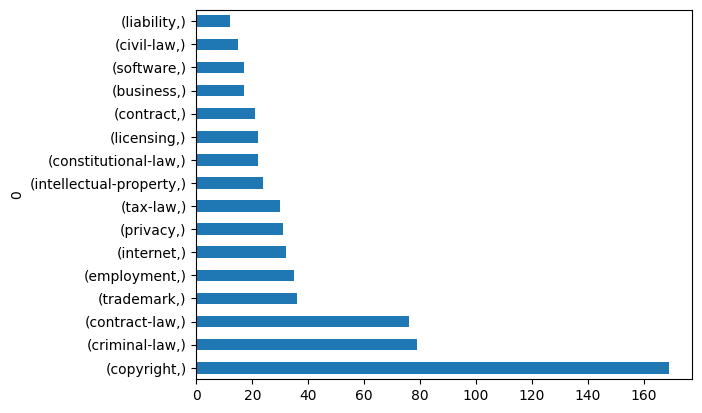

In [10]:
train_labels = pd.DataFrame(dataset['train']['label']).value_counts()
train_labels.plot(kind='barh')

<Axes: ylabel='0'>

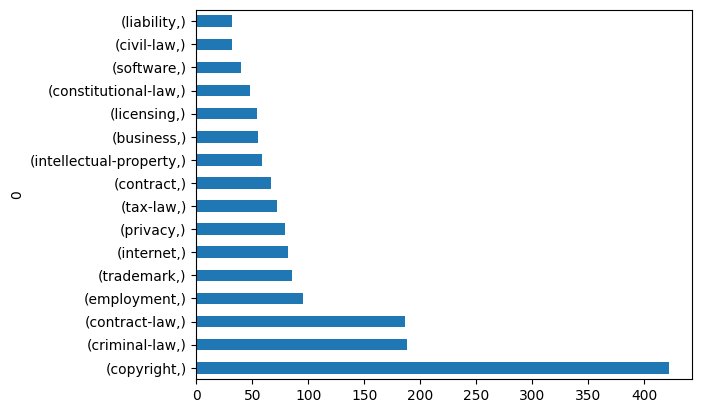

In [11]:
test_labels = pd.DataFrame(dataset['test']['label']).value_counts()
test_labels.plot(kind='barh')

<Axes: ylabel='0'>

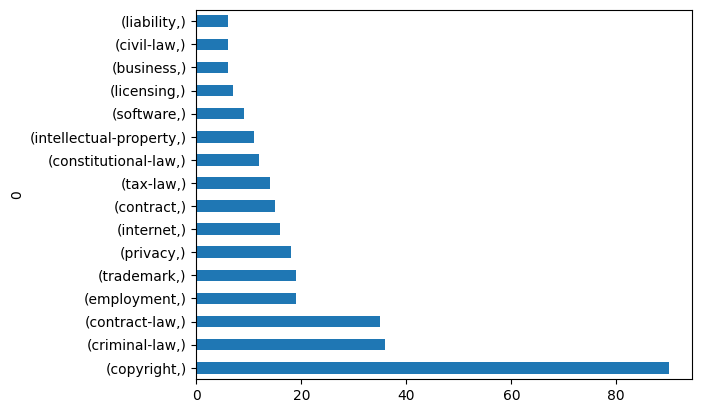

In [12]:
val_labels = pd.DataFrame(dataset['validation']['label']).value_counts()
val_labels.plot(kind='barh')

In [13]:
NUM_LABELS = len(train_labels)
print(NUM_LABELS)

16


In [14]:
# need to properly encode the labels 
from datasets import Dataset, Value, ClassLabel, Features

In [15]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None)}

In [16]:
features = Features({"text": Value("string"), "label": ClassLabel(num_classes=NUM_LABELS, names=train_labels.index.to_list())})

In [43]:
def encode_labels(dataset):
    encoded_data = pd.DataFrame(dataset)
    encoded_data = Dataset.from_pandas(encoded_data)
    encoded_data = encoded_data.class_encode_column("label")
    return encoded_data

In [69]:
train_data = encode_labels(dataset['train'])
test_data = encode_labels(dataset['test'])

Casting to class labels:   0%|          | 0/638 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1596 [00:00<?, ? examples/s]

In [53]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['business', 'civil-law', 'constitutional-law', 'contract', 'contract-law', 'copyright', 'criminal-law', 'employment', 'intellectual-property', 'internet', 'liability', 'licensing', 'privacy', 'software', 'tax-law', 'trademark'], id=None)}

In [61]:
from transformers import AutoTokenizer

In [63]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [65]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [71]:
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/638 [00:00<?, ? examples/s]

Map:   0%|          | 0/1596 [00:00<?, ? examples/s]

In [73]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 638
})

In [75]:
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

In [77]:
from transformers import AutoModelForSequenceClassification

In [79]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, torch_dtype="auto")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
from transformers import TrainingArguments

In [83]:
training_args = TrainingArguments(output_dir="test_dir", eval_strategy="epoch")

In [85]:
import numpy as np
import evaluate

In [87]:
metric = evaluate.load("accuracy")

In [88]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [91]:
from transformers import Trainer

In [93]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.573388,0.563910
